# Workshop 9

Regression Trees. Random Forest. Boosting. 


In [1]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Class DecisionTreeClassifier in Scikit-learn
The main parameters of the [`sklearn.tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class:

- `max_depth` – the maximum depth of the tree
- `max_features` - the maximum number of features to search for the best partition (this is necessary because with a large number of variables it'll be "expensive" to look for the best (according to the information gain-type criterion) partition among *all* variables)
- `min_samples_leaf` – the minimum number of objects in a leaf.This parameter has a clear interpretation: for example, if it is equal to 5, the tree will produce only those classifying rules that are true for at least 5 objects

The parameters of tree need to be set depending on the input data, and it is usually done with the help of *cross-validation*, more on it below.

### Decision Tree in the Regression Problem

When forecasting the quantitative variable, the idea of the ​​tree construction remains the same, but the quality criteria changes: 

- The dispersion around the mean: 

$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $

where $\ell$ is the number of objects in the leaf, $y_i$ is value of the target variable.Simply put, by minimizing the variance around the mean, we look for variables that divide the training set so that the values of the target variable in each leaf are roughly equal.

The Choice of Model Parameters and Cross-Validation
The main task of learning algorithms is to be able to generalize, that is, work well on the new data.Since we can't right away check the model performance on the new data ('cause we need to make a prediction for them, that is we don't know the true values of the target variable for them), it is necessary to sacrifice a small portion of the data to check the quality of the model on it.
Most often this is done in one of two ways:
putting aside a part of the dataset (held-out/hold-out set).In this approach, we reserve a fraction of the training set (typically from 20% to 40%), train the model on the rest of the data (60-80% of the original set) and compute some performance metric for the model (for example, the most simple one - the proportion of correct answers in the classification problem) on the hold-out set.
cross-validation. The most frequent case here is K-fold cross-validation

In [2]:
#data(solubility)
train_df = pd.read_csv('solTrainXtrans.csv').astype('int')
y = pd.read_csv('solTrainY.csv').astype('int')
train_df.drop('Unnamed: 0',axis=1,inplace=True)
y.drop('Unnamed: 0',axis=1,inplace=True)


In [3]:
train_df.head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
0,0,1,0,0,1,0,0,1,0,0,...,4,0,0,0,0,0,1,-1,6,6
1,0,1,0,1,1,1,1,1,0,0,...,5,0,0,0,0,0,1,0,9,12
2,1,1,1,1,1,0,0,1,0,1,...,4,0,1,0,0,0,0,0,8,8
3,0,0,1,0,0,0,1,0,0,0,...,3,0,0,0,0,0,0,-2,0,0
4,0,0,1,1,1,1,0,0,1,0,...,3,0,0,0,0,0,0,0,9,9


Let's allocate 70% of the set for training and 30% will be a hold-out set. Hold-out set will not in any way be involved in tuning the parameters of the models. We'll use it in the end, after this tuning, to assess the quality of the resulting model.

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.values, y.values,
                                                     test_size=.3, random_state=17)

### Decision tree without parameter tuning

In [8]:
tree = DecisionTreeRegressor(max_depth=3, random_state=17).fit(X_train, y_train)

In [9]:
export_graphviz(tree, 'tree1.dot', filled=True, 
                feature_names=train_df.columns.values)

In [10]:
!dot -Tpng tree1.dot -o tree1.png

![alt text](tree1.png "Tree")

In [11]:
tree_pred_valid = tree.predict(X_valid)

In [12]:
tree_acc_valid = r2_score(y_valid, tree_pred_valid)
tree_acc_valid

0.55867837722203428

###  Decision tree with parameter tuning

In [13]:
tree_params = {'max_depth': list(range(3, 11))}

tree_grid = GridSearchCV(DecisionTreeRegressor(random_state=17), 
                         tree_params, 
                         cv=5, scoring='r2') 

tree_grid.fit(X_train, y_train)
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 4}
Best cross validaton score 0.697671965831


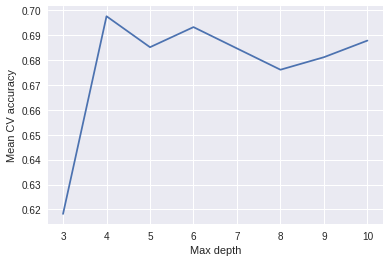

In [14]:
plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy');

In [15]:
export_graphviz(tree, 'tree2.dot', filled=True, 
                feature_names=train_df.columns.values)

In [16]:
!dot -Tpng tree2.dot -o tree2.png

![alt text](tree2.png "Tree")

In [17]:
tuned_tree_acc_valid = r2_score(y_valid, 
                                      tree_grid.predict(X_valid))
tuned_tree_acc_valid

0.59314164095518651

In [18]:
tuned_tree_acc_valid / tree_acc_valid - 1

0.061687126508308765

### Random forest without parameter tuning

In [19]:
first_forest = RandomForestRegressor(max_depth=3, random_state=17, n_jobs=-1)
first_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False)

In [20]:
first_forest_acc_valid = r2_score(y_valid, 
                                      first_forest.predict(X_valid))
first_forest_acc_valid

0.64294402893453317

### Variable Importance

In [21]:
pd.DataFrame(first_forest.feature_importances_, index=train_df.columns,
            columns=['Importance']).sort_values(by='Importance',
                                               ascending=False)

,Importance
FP076,0.271209
MolWeight,0.148961
SurfaceArea2,0.133569
FP044,0.118588
SurfaceArea1,0.112656
NumCarbon,0.058932
FP070,0.032332
NumRotBonds,0.030976
NumMultBonds,0.022426
FP092,0.020229


### Random forest with parameter tuning


In [22]:
%%time
forest_params = {'max_depth': list(range(8,14)),
                 'min_samples_leaf': list(range(3,8))}

locally_best_forest = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                                 forest_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                  scoring='r2')
locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.5s finished


CPU times: user 1.45 s, sys: 20 ms, total: 1.47 s
Wall time: 13.8 s


In [23]:
locally_best_forest.best_params_, round(locally_best_forest.best_score_, 3)

({'max_depth': 11, 'min_samples_leaf': 3}, 0.82199999999999995)

In [24]:
locally_best_forest_acc_valid = r2_score(y_valid, 
                                      first_forest.predict(X_valid))
locally_best_forest_acc_valid

0.64294402893453317

Make a prediction for test data.

In [25]:
tuned_forest_predictions = locally_best_forest.predict(X_valid) 
r2_score(y_valid,tuned_forest_predictions)

0.77884032607437204

### Boosting

In [28]:
import xgboost
from xgboost import XGBRegressor

In [40]:

xreg = XGBRegressor(n_estimators=100, subsample=0.5,
                                      random_state=42)  
xreg.fit(X_train, y_train)  
xreg.predict(X_valid)
print (xreg.predict)

<bound method XGBModel.predict of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)>


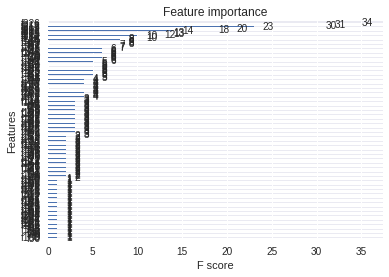

In [43]:
xgboost.plot_importance(xreg);